In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import pandas as pd
train = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train.csv")


In [3]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import cv2


In [4]:
cols = [
    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 
    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 
    'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 
    'CVC - Normal', 'Swan Ganz Catheter Present'
]

fig = make_subplots(rows=4, cols=3)

traces = [
    go.Bar(
        x=[0, 1], 
        y=[
            len(train[train[col]==0]),
            len(train[train[col]==1])
        ], 
        name=col,
        text = [
            str(round(100 * len(train[train[col]==0]) / len(train), 2)) + '%',
            str(round(100 * len(train[train[col]==1]) / len(train), 2)) + '%'
        ],
        textposition='auto'
    ) for col in cols
]

for i in range(len(traces)):
    fig.append_trace(traces[i], (i // 3) + 1, (i % 3)  +1)

fig.update_layout(
    title_text='Train columns',
    height=1200,
    width=1000
)

fig.show()


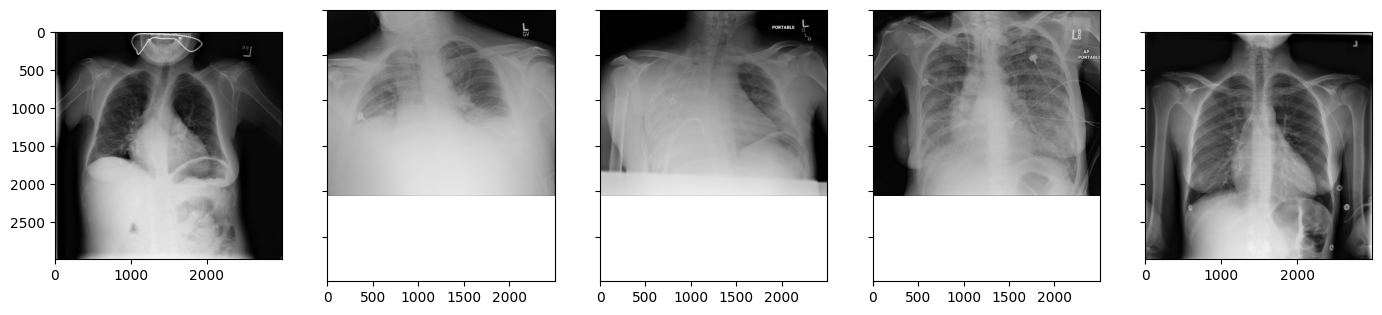

In [5]:
import os
f, plots = plt.subplots(1, 5, sharex='col', sharey='row', figsize=(17, 17))
samples = train.sample(n=5, random_state=666)['StudyInstanceUID'].values

for i in range(5):
    image = cv2.imread(os.path.join("/kaggle/input/ranzcr-clip-catheter-line-classification/train/", f"{samples[i]}.jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plots[i].imshow(image)


In [6]:
train.iloc[:, 1:-1].sum()


ETT - Abnormal                   76
ETT - Borderline               1027
ETT - Normal                   6503
NGT - Abnormal                  254
NGT - Borderline                487
NGT - Incompletely Imaged      2453
NGT - Normal                   4310
CVC - Abnormal                 2895
CVC - Borderline               7632
CVC - Normal                  19172
Swan Ganz Catheter Present      739
dtype: int64

(array([5., 2., 1., 2., 0., 0., 0., 0., 0., 1.]),
 array([   76. ,  1985.6,  3895.2,  5804.8,  7714.4,  9624. , 11533.6,
        13443.2, 15352.8, 17262.4, 19172. ]),
 <BarContainer object of 10 artists>)

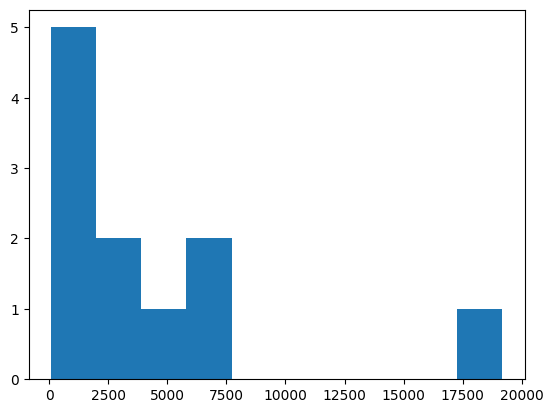

In [7]:
plt.hist(train.iloc[:, 1:-1].sum())


In [8]:
import random, os
import numpy as np
import torch
from fastai.vision.all import *
from fastai.callback import mixup
path = Path('../input/ranzcr-clip-catheter-line-classification/')
path.ls()


(#12) [Path('../input/ranzcr-clip-catheter-line-classification/train'),Path('../input/ranzcr-clip-catheter-line-classification/description.md'),Path('../input/ranzcr-clip-catheter-line-classification/train.csv'),Path('../input/ranzcr-clip-catheter-line-classification/train.csv.zip'),Path('../input/ranzcr-clip-catheter-line-classification/train_annotations.csv.zip'),Path('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv'),Path('../input/ranzcr-clip-catheter-line-classification/test.zip'),Path('../input/ranzcr-clip-catheter-line-classification/train_annotations.csv'),Path('../input/ranzcr-clip-catheter-line-classification/train.zip'),Path('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv.zip'),Path('../input/ranzcr-clip-catheter-line-classification/test'),Path('../input/ranzcr-clip-catheter-line-classification/ranzcr-clip-catheter-line-classification')]

In [9]:
train['path'] = train.StudyInstanceUID.map(lambda x:str(path / 'train' / x)+'.jpg')


In [10]:
labels = list(train.columns[1:12].values)
labels


['ETT - Abnormal',
 'ETT - Borderline',
 'ETT - Normal',
 'NGT - Abnormal',
 'NGT - Borderline',
 'NGT - Incompletely Imaged',
 'NGT - Normal',
 'CVC - Abnormal',
 'CVC - Borderline',
 'CVC - Normal',
 'Swan Ganz Catheter Present']

In [11]:
def get_y(fname):
    return fname[1:12].values.astype(np.float32)

def get_x(fname):
    return fname[-1]


In [12]:
item_tfms = RandomResizedCrop(256, min_scale=0.75, ratio=(1.,1.))

dls = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=labels)),
                        get_x = get_x,get_y = get_y,  
                        item_tfms = item_tfms)


/tmp/ipykernel_8/601762712.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



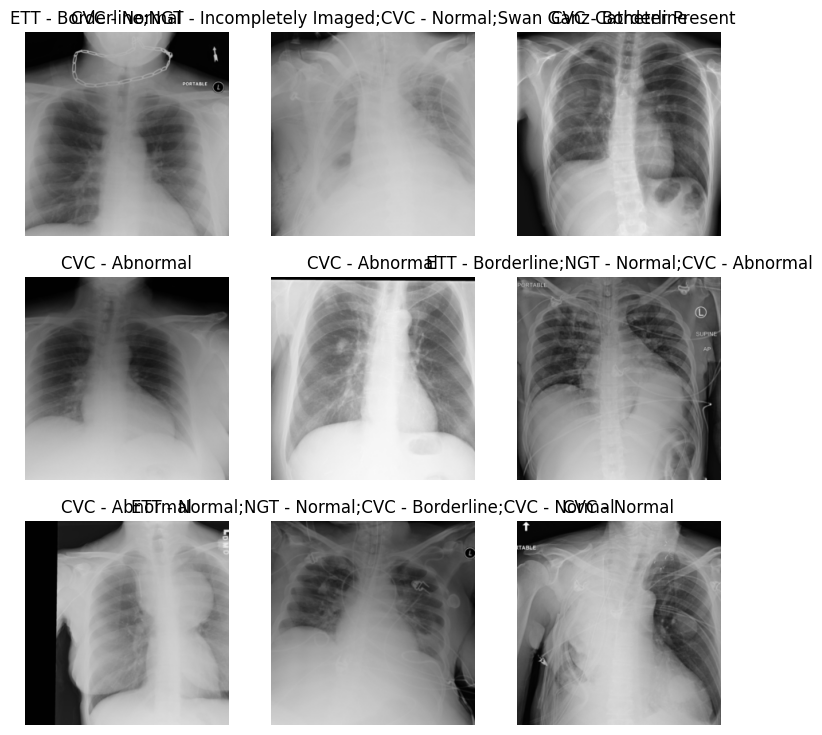

In [13]:
dls = dls.dataloaders(train)
dls.show_batch()


In [14]:
learn = cnn_learner(dls, resnet152, metrics = [accuracy_multi], cbs=[mixup.MixUp()], model_dir="/tmp/model/").to_native_fp16()


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning:

`cnn_learner` has been renamed to `vision_learner` -- please update your code

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 115MB/s]


AttributeError: 'Sequential' object has no attribute 'to_native_fp16'

In [15]:
learn = cnn_learner(dls, resnet50, metrics = [accuracy_multi], cbs=[mixup.MixUp()], model_dir="/tmp/model/").to_native_fp16()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


AttributeError: 'Sequential' object has no attribute 'to_native_fp16'

In [16]:
learn.lr_find()


NameError: name 'learn' is not defined

In [17]:
learn.fine_tune(3, 2e-2)


NameError: name 'learn' is not defined

In [18]:
learn = learn.to_native_fp32()


NameError: name 'learn' is not defined

In [19]:
path = Path('../input/ranzcr-clip-catheter-line-classification')


In [20]:
submission_df = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')
submission_df.iloc[:,1:] = submission_df.iloc[:,1:].astype(float)


/tmp/ipykernel_8/3712189479.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3004    0.0
3005    0.0
3006    0.0
3007    0.0
3008    0.0
Name: ETT - Abnormal, Length: 3009, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_8/3712189479.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3004    0.0
3005    0.0
3006    0.0
3007    0.0
3008    0.0
Name: ETT - Borderline, Length: 3009, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_8/3712189479.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Va

In [21]:
test_data_path = submission_df['StudyInstanceUID'].apply(lambda x: path/'test'/(x+'.jpg'))
tst_dl = learn.dls.test_dl(test_data_path)
preds,targs = learn.tta(dl = tst_dl)


NameError: name 'learn' is not defined

In [22]:
columns = list(train.columns[1:12])


In [23]:
submission_df[columns] = pd.DataFrame(preds,columns=columns)
# submission_df


NameError: name 'preds' is not defined

In [24]:
submission_df.to_csv('submission.csv',index=False)  
